# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [ ]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

# statistical analysis
from scipy import stats

## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create rows `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create rows `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created rows for paper `P17`.
- Print the resulting dataframe.

In [26]:
def stat_overall_scores(scores_df,function=np.mean):
    """
    Function that takes the list of overall scores of each paper and return a 
    list containing the result of the specified function (mean or std)
    
    Arguments :
                @scores_df <DataFrame> : for each paper, contains its peer review scores
                @function <str> : 'np.mean' or 'np.std'
                
    Return :
                @overall_scores <list> : mean or std of the overall scores given by peers
    """
    
    overall_scores = [function([paper[peer]['scores']['overall_score']#peer overall scores
                                for peer in paper])
                      for paper in scores_df]
    return overall_scores

# Loading of the dataset
PATH = "./data/acl18_v1_numerical_final.json"
ACL_df = pd.read_json(PATH)

#Creation of new columns
ACL_df = ACL_df.assign(overall_score_before_avg = 
                       stat_overall_scores(ACL_df.scores_before)).copy(deep=True)
ACL_df = ACL_df.assign(overall_score_before_std = 
                       stat_overall_scores(ACL_df.scores_before,np.std)).copy(deep=True)
ACL_df = ACL_df.assign(overall_score_after_avg = 
                       stat_overall_scores(ACL_df.scores_after)).copy(deep=True)
ACL_df = ACL_df.assign(overall_score_after_std = 
                       stat_overall_scores(ACL_df.scores_after,np.std)).copy(deep=True)

#Deletion of the useless columns
ACL_df = ACL_df.drop(columns=['scores_before','scores_after'])

#Display results
display(ACL_df[ACL_df.tmp_id=="P17"][['tmp_id',
                                      'overall_score_before_avg',
                                      'overall_score_before_std',
                                      'overall_score_after_avg',
                                      'overall_score_after_std']])
display(ACL_df) 

,tmp_id,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,overall_score_after_std
16,P17,4.5,0.5,4.5,0.5


,tmp_id,status,submission_type,track,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,overall_score_after_std
0,P1,Reject,Long,Machine Learning,True,2.500000,0.500000,2.500000,0.500000
1,P2,Reject,Long,Question Answering,True,3.333333,0.942809,3.333333,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,True,4.666667,0.471405,4.666667,0.471405
3,P4,Reject,Short,Machine Learning,True,3.000000,0.816497,2.666667,1.247219
4,P5,Reject,Long,Document Analysis,True,3.000000,0.000000,2.500000,0.500000
...,...,...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,True,2.333333,0.471405,2.333333,0.471405
1541,P1542,Reject,Long,Machine Learning,False,2.000000,0.816497,2.000000,0.816497
1542,P1543,Reject,Long,Machine Learning,True,2.666667,0.942809,2.666667,0.942809
1543,P1544,Reject,Short,Social Media,False,2.000000,0.000000,2.000000,0.000000


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

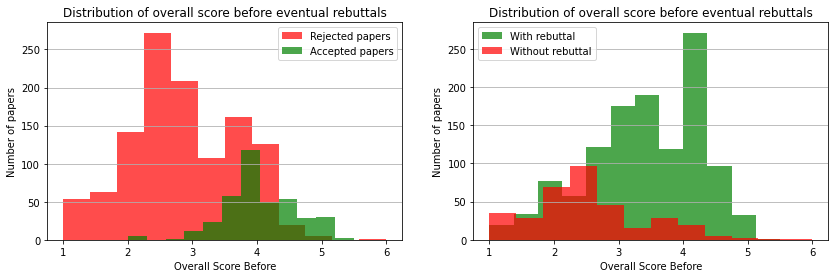

In [27]:
z = stats.norm.ppf(0.975) # z-score for 95% confidence intervals (1.96)
accept_df = ACL_df[ACL_df.status == 'Accept']
reject_df = ACL_df[ACL_df.status == 'Reject']
with_rebuttals_df = ACL_df[ACL_df.had_rebuttal]
without_rebuttals_df = ACL_df[ACL_df.had_rebuttal==False]

Nbin = 12
fig, (A,B) = plt.subplots(1, 2, figsize=(14,4))

#Distribution of accepted and rejected papers depending on their mean overall score
A.hist(reject_df.overall_score_before_avg,color='r',alpha=.7,bins=Nbin)
A.hist(accept_df.overall_score_before_avg,color='g',alpha=.7,bins=Nbin)
A.legend(['Rejected papers','Accepted papers'])
A.grid(axis='y')
A.set_xlabel('Overall Score Before')
A.set_ylabel('Number of papers')
A.set_title("Distribution of overall score before eventual rebuttals")

#Distribution of papers with or without rebuttals depending on their mean overall score
B.hist(with_rebuttals_df.overall_score_before_avg,color='g',alpha=.7,bins=Nbin)
B.hist(without_rebuttals_df.overall_score_before_avg,color='r',alpha=.7,bins=Nbin)
B.legend(['With rebuttal','Without rebuttal'])
B.grid(axis='y')
B.set_xlabel('Overall Score Before')
B.set_ylabel('Number of papers')
B.set_title("Distribution of overall score before eventual rebuttals")

plt.show()

We notice two things :
- Accepted paper have mainly high overall scores before eventual rebuttals. 
- Paper without rebuttals seems to have lower overall scores before eventual rebuttals. 

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

**Answer:** By looking at our histograms : a paper that has a rebuttal is more likely to have a high overall score before, and a paper that has a high overall score before is more likely to be accepted. **Hence it seems more likely to be accepted when you do rebuttals.**

Looking a little bit deeper, we provide the following statistics :

In [28]:
# Recuperation of statistics
numerator = ACL_df.query('status=="Accept" and had_rebuttal==True').shape[0]
denominator = ACL_df.query('had_rebuttal==True').shape[0]
numerator2 = ACL_df.query('status=="Accept" and had_rebuttal==False').shape[0]
denominator2 = ACL_df.query('had_rebuttal==False').shape[0]
print(f"There are {numerator} paper with rebuttals that were accepted.")
print(f"There are {denominator} paper with rebuttals.")
print(f"There are {numerator2} paper without rebuttals that were accepted.")
print(f"There are {denominator2} paper without rebuttals.")

There are 350 paper with rebuttals that were accepted.
There are 1192 paper with rebuttals.
There are 29 paper without rebuttals that were accepted.
There are 346 paper without rebuttals.


|                  | Accepted  | Rejected |
|------------------|-----------|----------|
| With rebuttal    |   350     |  842     |
| Without rebuttal |   29      |  317     |

If $A$ is the event : "The paper is accepted" and $R$ : "The paper had a rebuttal". Let's compute the following values :

$$P(A|R)=\frac{P(A\cap R)}{P(R)}=\frac{350}{1192}\approx 0.294$$

Naïvely, we might conclude that having a rebuttal leads to a probability of being accepted inferior to 0.5. Hence, having a rebuttal does not imply that the paper will be accepted. 

However, when comparing this result to the probability of being accepted:

$$P\left(A\right)=\frac{350+29}{842+317+350+29}\approx 0.246$$

We understand that being accepted is a rare event, and having a rebuttal actually increases your chances to be accepted. 

In fact, not to do a rebuttal even makes chances to be accepted a lot smaller:
$$P\left(A|\overline{R}\right)=\frac{P\left(A\cap \overline{R}\right)}{P\left(\overline{R}\right)}=\frac{29}{346}\approx 0.0838$$

Only considering these elements, **we might conclude that rebuttals seems to help being accepted**. This could be because if you have a low score before, you might have not been understood by your peers, so doing a rebuttal can clarify you paper and increase your score after, what leads your paper to be accepted.

This would however be more careful to do a deeper anlysis to check if some confounders could not threaten our findings.

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

,track,percentage_with_rebuttal,confidence_interval_95
0,Dialogue and Interactive Systems,77.528090,8.671668
1,Discourse and Pragmatics,80.434783,11.463928
2,Document Analysis,73.000000,8.701445
3,Generation,77.966102,10.575981
4,Information Extraction and Text Mining,76.836158,6.215121
5,Linguistic Theories Cognitive Modeling and Psy...,75.000000,17.323798
6,Machine Learning,80.869565,7.188763
7,Machine Translation,82.075472,7.301729
8,Multidisciplinary and Area Chair COI,68.000000,10.557155
9,Multilinguality,80.645161,13.907568


<Figure size 720x288 with 0 Axes>

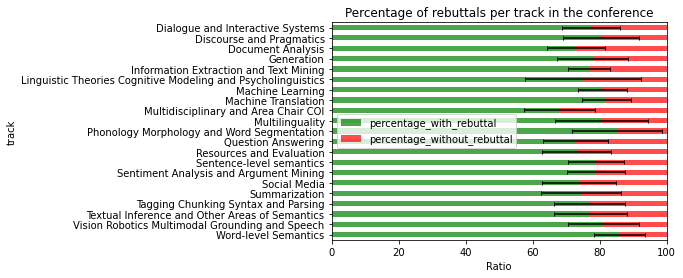

In [29]:
track_df = ACL_df[['track','had_rebuttal']].groupby('track').had_rebuttal

# Percentage of paper with rebuttals among tracks
stat_dict = {"track":[], "percentage_with_rebuttal":[], "confidence_interval_95":[]}
for track in track_df:
    stat_dict["track"].append(track[0])
    stat_dict["percentage_with_rebuttal"].append(track[1].mean()*100)
    stat_dict["confidence_interval_95"].append(z*track[1].sem(ddof=0)*100)
df_stat = pd.DataFrame(stat_dict)
display( df_stat )
df_stat['percentage_without_rebuttal'] = 100-df_stat['percentage_with_rebuttal']

# Corresponding plot
plt.figure(figsize=(10, 4))
ax = df_stat.plot(x='track', y=['percentage_with_rebuttal','percentage_without_rebuttal'],
                  kind='barh', stacked=True, color=['green', 'red'], alpha=0.7)
ax.invert_yaxis()
for i, value in enumerate(df_stat["percentage_with_rebuttal"]):
    # add the confidence interval at 95% to each track
    plt.errorbar(value, i, xerr=df_stat["confidence_interval_95"].iloc[i],
                 linestyle='', color='black', capsize=2)
plt.title('Percentage of rebuttals per track in the conference')
plt.xlabel('Ratio')
plt.xlim((0, 100))
plt.show()

**Answer:**

**Theoretically,** to design a statistical test to refute that all tracks have the same fraction of papers with rebuttals, we consider the latter to be true. This means that if we had access to a large amount of papers for each track, we should have the same fraction of papers with rebuttals for each of them. But here we just have a small sample, and this fraction can fluctuate from the one of the absolute distribution.

This is why we would use a number $t$, characterizing the difference between each empirical percentage and the theoretical one, and taking into account the size of each sample (a given bias found for a track with many papers should be more penlized than for a track with few papers). For intance, $t$ could be a weighted sum of the squared differences between theroetical and empirical percentages.

The most important would be then to find the probability that a difference equal or higher than $t$ had be found by luck. If this probability is high, this means it is possible that all our percentages comes from the same initial distribution. But if it is found to be really low, then the difference $t$ (that is supposed to be non-zero) is not due to chance, and this means our initial hypothesis that every track has the same fraction of papers with rebuttal is false.

**In practice,**  an adapted test for this is the ANalysis Of VAriance (ANOVA test). It will compute a F-test to characterize whether the differences in percentages areseen in the previous graph are due to chance. We will obtain a p-value which allows us to reject the  null hypothesis ("all tracks have the same fraction of papers with rebuttals") if and only if below 0.05.

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [30]:
for track_name in ACL_df.track:
    new_column=track_name+"-onehot"
    ACL_df[new_column]=ACL_df.track.apply(lambda x: int(x==track_name))

for column in sorted(ACL_df.columns):
    print("- "+column)

- Dialogue and Interactive Systems-onehot
- Discourse and Pragmatics-onehot
- Document Analysis-onehot
- Generation-onehot
- Information Extraction and Text Mining-onehot
- Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot
- Machine Learning-onehot
- Machine Translation-onehot
- Multidisciplinary and Area Chair COI-onehot
- Multilinguality-onehot
- Phonology Morphology and Word Segmentation-onehot
- Question Answering-onehot
- Resources and Evaluation-onehot
- Sentence-level semantics-onehot
- Sentiment Analysis and Argument Mining-onehot
- Social Media-onehot
- Summarization-onehot
- Tagging Chunking Syntax and Parsing-onehot
- Textual Inference and Other Areas of Semantics-onehot
- Vision Robotics Multimodal Grounding and Speech-onehot
- Word-level Semantics-onehot
- had_rebuttal
- overall_score_after_avg
- overall_score_after_std
- overall_score_before_avg
- overall_score_before_std
- status
- submission_type
- tmp_id
- track



**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [31]:
ACL_df['had_rebuttal_int']=ACL_df.had_rebuttal.apply(lambda x: int(x))
ACL_df['accepted_int']=ACL_df.status.apply(lambda x: int(x=="Accept"))
display(ACL_df[['had_rebuttal','had_rebuttal_int','status','accepted_int']])

,had_rebuttal,had_rebuttal_int,status,accepted_int
0,True,1,Reject,0
1,True,1,Reject,0
2,True,1,Accept,1
3,True,1,Reject,0
4,True,1,Reject,0
...,...,...,...,...
1540,True,1,Reject,0
1541,False,0,Reject,0
1542,True,1,Reject,0
1543,False,0,Reject,0



**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [32]:
def numpy_helper(df, cols):
    """
    Function to obtain a numpy array from a dataframe
    
    Arguments :
        @df <pandas.DataFrame>: Input dataframe 
        @cols <list>: columns
    """
    return np.array(df[cols].values, dtype=float)


**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [33]:
# Select necessary columns from the dataframe
X_cols = ["overall_score_before_avg","overall_score_before_std"]
for col in ACL_df.columns:
    if ("-onehot" in col):
        X_cols.append(col)
X_cols.append("had_rebuttal_int")

X = numpy_helper(ACL_df, X_cols)
y = numpy_helper(ACL_df, ["accepted_int"])[:,0]

# Print the shapes of X and y
print(f"X shape : {X.shape} ; y shape : {y.shape}.")

X shape : (1538, 24) ; y shape : (1538,).



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [34]:
#Remove the column 'had_rebuttal_int' (last one of X) and fit model 1
classifier1 = GradientBoostingClassifier().fit(X[:,0:-1],y)
#Fit model 2 on the whole array X
classifier2 = GradientBoostingClassifier().fit(X,y)

cv1 = cross_validate(classifier1, X[:,0:-1], y, cv=30,
                     scoring=('accuracy', 'precision', 'recall'))
cv2 = cross_validate(classifier2, X, y, cv=30,
                     scoring=('accuracy', 'precision', 'recall'))


**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


In [35]:
#T-test between the two models
t_statistic, p_value = stats.ttest_rel(cv1["test_accuracy"], cv2["test_accuracy"])
alpha = 0.05  # significance level
print("p-value : ", p_value)

if p_value < alpha:
    print("The difference in accuracy is statistically significant.")
else:
    print("The difference in accuracy is NOT statistically significant.")

p-value :  0.48357829299551125
The difference in accuracy is NOT statistically significant.


**Answer:** 

The difference in accuracy between models donsidering 
- the `score_before_avg`, `score_after_avg` and the `-onehot` features (1) 
- or all these features plus the `had_rebuttal_int` (2)

is **NOT** significant.

**2.7** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

**Answer:** In task 1, we found that the conditional probabilities of acceptation knowing whether or not there had been a rebuttal were very  different. This lead us into thinking that rebuttals help being accepted. 
However, in task 2, we trained 2 models to predict a binary outcome: whether or not a paper is accepted.
Both models use common features (namely track and scores), but in addition, model 2 considers the binary predictor `had_rebuttal_int`, which model 1 does not. We then look at the accuracy of both models, to assess the quality of each.
We compare the accuracies with a t-test, to understand if adding the `had_rebuttal_int` feature significantly increases the accuracy of the prediction. 

In 2.6 we find out a p-value of 0.484, way superior to 0.05. Therefore, **we cannot conclude that rebuttals play a significant role** in the chances of being accepted.

The advantages of the analysis performed in 2.6 are the following: 
- We added predictors: the tracks and the scores. This refines the analysis (for instance, some tracks could be more accepted/represented than others, which could have twisted the results in task 1). Scores are obviously linked with acceptance.
- Using classifiers' accuracy (with and without rebuttal feature) to better understand the role of this feature in predicting acceptance is more relevant than just looking at the observed percentages, which are only one representation of a fixed dataset.

## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regression. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [36]:
# creation and display of the three models
formula1 = 'accepted_int ~ had_rebuttal_int'
formula2 = 'accepted_int ~ overall_score_after_avg'
formula3 = 'had_rebuttal_int ~ overall_score_before_avg'

model1 = smf.ols(formula=formula1, data=ACL_df).fit()
model2 = smf.ols(formula=formula2, data=ACL_df).fit()
model3 = smf.ols(formula=formula3, data=ACL_df).fit()

display(model1.summary(title="Model 1 Summary"))
display(model2.summary(title="Model 2 Summary"))
display(model3.summary(title="Model 3 Summary"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Model 1 Summary                                
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           8.24e-16
Time:                        20:22:59   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0838      0.023      3.693      0.000       0.039       0.128
had_rebuttal_int     0.2098      0.026      8.138      0.000       0.159       0.260
==============================================================================
Omnibus:                      271.753   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.377
Skew:                           1.075   Prob(JB):                     3.65e-71
Kurtosis:                       2.336   Cond. No.                         4.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Model 2 Summary                                
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):          1.58e-173
Time:                        20:22:59   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6558      0.029    -22.339      0.000      -0.713      -0.598
overall_score_after_avg     0.2860      0.009     32.111      0.000       0.269       0.303
==============================================================================
Omnibus:                      110.778   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.680
Skew:                           0.256   Prob(JB):                     5.99e-12
Kurtosis:                       2.263   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Model 3 Summary                                
==============================================================================
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.89e-50
Time:                        20:22:59   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2527      0.035      7.195      0.000       0.184       0.322
overall_score_before_avg     0.1651      0.011     15.499      0.000       0.144       0.186
==============================================================================
Omnibus:                      201.621   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.526
Skew:                          -1.060   Prob(JB):                     2.23e-63
Kurtosis:                       2.890   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variables in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



**Answer:** The only binary independent variable is `had_rebuttal_int`, in model 1, whose coefficients are:
- Coefficients: slope = 0.2098 and intercept = 0.0838
- P-value: < 0.001

In Model 1, the coefficient associated with `had_rebuttal_int` is 0.2098. This means that, on average, papers with a rebuttal have a 0.2098 increase in the log-odds of being accepted compared to papers without a rebuttal. The p-value of < 0.001 indicates that this coefficient is statistically significant, suggesting that the presence of a rebuttal has a significant impact on the acceptance of papers. 

We can notice that these coefficients correspond to the percentages we had computed in question 1.3: 
- The intercept (0.0838) is the percentage of papers that were accepted without rebuttal (`had_rebuttal_int` = 0)
- The slope (0.2098) is the average acceptance difference between papers with and without rebuttals.


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


**Answer:**



1. Correlation between `accepted_int` and `had_rebuttal_int`:
   - Sign: Positive
   - Statistical Significance: Yes (p-value < 0.001)
   
Therefore, **papers with a rebuttal are more likely to be accepted**.


2. Correlation between `accepted_int` and `overall_score_after_avg`:
   - Sign: Positive
   - Statistical Significance: Yes (p-value < 0.001)
   
Therefore, **papers with a high overall score after average are more likely to be accepted**.
   
3. Correlation between `had_rebuttal_int` and `overall_score_before_avg`:
   - Sign: Positive
   - Statistical Significance: Yes (p-value < 0.001)
   
Therefore, **papers with a rebuttal are more likely to have a high overall score before average**.
   



**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int`than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


**Answer:** True.

We look at the adjusted R squared coefficients of models 2 and 3 : $R_{model2}^2 = 0.401$ and $R_{model3}^2 = 0.135$.

Since the R squared coefficient assesses the predictor's ability to explain the variance of the response variable, we conclude that `overall_score_after_avg` explains more of the variance in `accepted_int` than `overall_score_before_avg` explains of `had_rebuttal_int`.


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

**Answer:** Track can have bias (the same group of authors, that have always the same method) and influence every trait.
- Tr->Sb (The track can have a bias towards certain types of submissions)
- Tr->Sa (The track can influence the acceptance of submissions based on its specific criteria and preferences)
- Tr->Re (The track can influence the selection of reviewers who are experts in the specific area covered by the track)
- Tr->Ac (The track can influence the final decision on whether a submission should be accepted or rejected)
- Sb->Sa (A submission bias can lead to a perpetuation of certain types of papers being accepted or rejected consistently)
- Sb->Re (If authors know they have a bad score due to submission bias, they may try to provide additional explanations or justifications for their paper to the reviewers)
- Sb->Ac (Submission bias can indirectly influence the acceptance decision by affecting the pool of papers available for consideration)
- Re->Sa (Reviewers can provide feedback and suggestions that can potentially improve the quality and acceptance chances of a submission)
- Re->Ac (Reviewers' evaluations and recommendations can indirectly influence the final acceptance decision made by the program committee)
- Sa->Ac (The acceptance decision is influenced by the quality and suitability of the submissions)

**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

**Answer:**  The problem is that it does not take into account the effect of confounders. Indeed, we have proven in question 3.2 that there was a positive correlation between having rebuttals and being accepted. This may mislead us into thinking that having rebuttals effectively increases chances of being accepted.

However, the other two analyses prove that positive correlations exist between: 
- having a good overall score before and having rebuttals (i)
- and having a good overall score after and being accepted (ii).

There might be a confounder that affects both the average scores between and after eventual rebuttals, and that effectivly accounts for the correlation being accepted ~ have a rebuttal. This could also be the consequence of the impact of `score_before_avg` on `score_after_avg`. The correlation would just be a consequence of another causality, due to one feature.

Another problem is that the papers on which we study the influence of rebuttals don't have the same initial features. So maybe papers with rebuttals are usually done by conscientious scholars who get good scores at the beginning, and would have passed even without rebuttals, whereas papers without rebuttals are done by non-experts who get terrible scores at the beginning and wouldn't even pass despite rebuttals. The track may also be important: for example, in a selective field, there could be less papers proposed and thus a higher acceptance ratio, that would not be due to rebuttals. **Therefore the optimal thing to do is to compare papers that have similar initial features** (track, score_before, ...) and see whether having a rebuttal really helps them be accepted.

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

In [37]:
#EXACT matching 
treatment_group = ACL_df[ACL_df['had_rebuttal_int']==1]
control_group = ACL_df[ACL_df['had_rebuttal_int']==0]
matched_samples = []
column_names_ACL = ACL_df[['tmp_id', 'status', 'submission_type',
            'track', 'had_rebuttal', 'overall_score_before_avg', 
            'overall_score_before_std', 'overall_score_after_avg', 
            'overall_score_after_std','had_rebuttal_int','accepted_int']].columns

#List of unique tracks 
Track_list = treatment_group['track'].unique()

#Loop on unique tracks 
for track in Track_list : 
    #List of the unique grades in the paper having the required track 
    grade_list = treatment_group[
        treatment_group['track']==track]['overall_score_before_avg'].unique()
    #Loop on unique grades
    for grade in grade_list : 
        #This is exectued for all the unique pairs (track,overall_score_avg)
        #We find the matching paper in both groups 
        pair_control = control_group[(control_group['track']== track)
                            & (control_group['overall_score_before_avg'] == grade)]
        pair_treatment = treatment_group[(treatment_group['track']== track)
                            & (treatment_group['overall_score_before_avg'] == grade)]
        
        nb_match = len(pair_control)
        if nb_match == 0 : 
            #No matching paper have been found in the control group
            continue 
        else : 
            #Addition of the two matched papers to the matched sample dataset 
            k = 0 
            for _,paper in pair_treatment.iterrows() : 
                pair = pair_control.iloc[k%nb_match]
                matched_samples.append([paper[col] for col in column_names_ACL])
                matched_samples.append([pair[col] for col in column_names_ACL])
                k+=1
    

matched_df = pd.DataFrame(matched_samples,columns = column_names_ACL)
display(matched_df)


,tmp_id,status,submission_type,track,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,overall_score_after_std,had_rebuttal_int,accepted_int
0,P1,Reject,Long,Machine Learning,True,2.500000,0.500000,2.500000,0.500000,1,0
1,P193,Reject,Long,Machine Learning,False,2.500000,0.500000,2.500000,0.500000,0,0
2,P727,Reject,Long,Machine Learning,True,2.500000,0.500000,2.333333,0.471405,1,0
3,P991,Reject,Short,Machine Learning,False,2.500000,1.500000,2.666667,0.471405,0,0
4,P4,Reject,Short,Machine Learning,True,3.000000,0.816497,2.666667,1.247219,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1355,P1157,Reject,Short,Social Media,False,1.500000,0.500000,1.500000,0.500000,0,0
1356,P644,Reject,Long,Social Media,True,2.666667,0.471405,2.666667,0.471405,1,0
1357,P1004,Reject,Long,Social Media,False,2.666667,0.471405,2.666667,0.471405,0,0
1358,P1234,Reject,Short,Social Media,True,2.666667,1.247219,2.666667,1.247219,1,0


**4.2** So far, we did not consider the `score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [38]:
mean_treatment= matched_df.query('had_rebuttal_int == 1').overall_score_before_std.mean()
mean_control  = matched_df.query('had_rebuttal_int == 0').overall_score_before_std.mean()
var_treatment = matched_df.query('had_rebuttal_int == 1').overall_score_before_std.var()
var_control   = matched_df.query('had_rebuttal_int == 0').overall_score_before_std.var()

# Calculus of the Standardized Mean Difference (SMD)
smd = abs(mean_treatment - mean_control) / np.sqrt(var_treatment + var_control)

# Check the given condition on the SMD
print("SMD:", smd)
if smd < 0.1:
    print("The score_before_std variable is balanced "+
          "across treatment and control groups.")
else:
    print("The score_before_std variable is NOT balanced "+
          "across treatment and control groups.")

SMD: 0.09462551768993871
The score_before_std variable is balanced across treatment and control groups.



**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [42]:
final_model = smf.ols(formula = 'accepted_int ~ had_rebuttal_int',
                      data = matched_df).fit()

display(final_model.summary())

print("The linear regression 'accepted_int ~ had_rebuttal_int' gives:")
print(f'intercep = {(np.round(final_model.params[0], 4))}') 
print(f'slope = {(np.round(final_model.params[1], 4))}')     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           accepted_int   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04719
Date:                Fri, 01 Dec 2023   Prob (F-statistic):              0.828
Time:                        21:26:20   Log-Likelihood:                -592.92
No. Observations:                1360   AIC:                             1190.
Df Residuals:                    1358   BIC:                             1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1662      0.014     11.572      0.000       0.138       0.194
had_rebuttal_int     0.0044      0.020      0.217      0.828      -0.035       0.044
==============================================================================
Omnibus:                      387.507   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              785.770
Skew:                           1.772   Prob(JB):                    2.36e-171
Kurtosis:                       4.141   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression 'accepted_int ~ had_rebuttal_int' gives:
intercep = 0.1662
slope = 0.0044



**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

**Answer i :**
The linear regression gives a slope of $0.0044$, so rebuttals seem to slightly increase the chances of being accepted. However, the p-value is so high (0.828) that we cannot conclude on the real impact of rebuttals on acceptance.

Results are different from what we had in Task 1 (where we had concluded that rebuttals helped being accepted) since now, we reduce the sample to only matched pairs by creating a control group and a treatment group (without and with rebuttals). This way, we only compare papers which have similar traits, which reduces the impact of predictors presented in Task 3. As regards the matching, we have matched papers only based on two criteria: the track and the overall score before, because only these two are not influenced (see graph in 3.5) by the possible presence of rebuttal.

Conversely, in Task 1, we naïvely compared all the papers, neither by taking any confounder into account, nor by clustering the papers into relevant and comparable subgroups. Therefore, we saw an illusional pattern when considering the whole group of papers, pattern that fades out when we consider relevant subgroups.

**Answer ii :** First, it is obviously irrelevant to use the covariates used to do the clustering. 
Indeed, by doing the matching, we created pairs that have the same track and score before. Therefore, these two parametes have their effect neutralised in the linear regression. It is useless to include them as covariates.
Also, we have checked that the standard deviation of scores before is balanced between treatment and control groups.

Remains the possibility of including the average score after as a covariate.
Such a linear regression would give: $Acceptance = \beta_0 + \beta_1*hadRebuttalInt + \beta_2*avgScoreAfter $.
`Avg_score_after` can be highly influenced by both score before and had_rebuttal. Therefore, it is either redundant to include it as a covariate, or even detrimental. Indeed, it could weaken the $\beta_1$ associated with `had_rebuttal` in the linear regression. If `had_rebuttal` has a great impact on `score_after_avg`, and `score_after_avg` has a great impact on `accepted_int`, we will observe a high correlation (great $\beta_2$) related to `score_after_avg`, and a small $\beta$ related to `had_rebuttal`, whereas in this case, the real causal link between rebuttal and acceptance could be attenuated by the apparently strong link between score_after and acceptance.)

Therefore, we do not need to include any other covariate.

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac
Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.
Does this uncontrolled confounder threaten the validity of your findings?


**Answer:**

This uncontrolled confounder threatens the **method** we use in this study.

- First, it will induces a bias in the composition of our treatment and control groups : since quality increases the chance of having a rebuttal, it also increases the chances of being in our treatment group. We should hence have more qualitative papers in the latter than in our control group. 
- And then, quality associated with rebuttal also increase the chance of being accepted : hence the treatment group should artificially have more accepted papers, not due to their rebuttals, but to quality.

The combination of those two influences, one that makes a discrimination between our two groups and one that boost acceptance in the treatment group due to quality and not only to rebuttals, can deeply change the results of our study.

However, when it comes to the findings, we concluded that rebuttals do not help significantly a paper to be accepted. Since the bias introduced by quality should lead to an artificial increase in acceptance for papers with rebuttals, conducting the same study but taking also into account quality should lead to the same conclusion. 

Hence this uncontrolled covariate does not threaten our final conclusion, which is that rebuttals do not help significantly your paper to be accepted.